# Image processing coursework 1

## Loading in images and dependencies

(568, 512, 3)
(568, 512, 3)


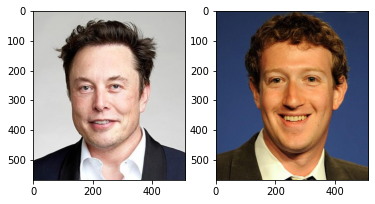

In [19]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import Delaunay
import os

image1 = plt.imread('Images/try1.jpg')
image2 = plt.imread('Images/try2.jpg')
# image2 = np.copy(image2[0:2814, 100:2210,:]) # sunak
# image2 = np.copy(image2[100:2914, 900:3010,:]) 
print(image1.shape)
print(image2.shape)
plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.subplot(1, 2, 2)
plt.imshow(image2)

## Detecting facial landmarks

In [22]:
def shape_to_np(shape, dtype="int"):
    '''
    convert the dlib shape to numpy ndarray
    '''
    coords = np.zeros((68, 2), dtype=dtype)
    for i in range(68):
        coords[i,0] = shape.part(i).x
        coords[i,1] = shape.part(i).y
    return coords

def landmark_detector(img):
    '''
    Outputs ndarray of landmarks for img
    '''
    import dlib
    # get the landmark detector
    print("importing model")
    dat_path = 'shape_predictor_68_face_landmarks.dat'
    file_path = 'shape_predictor_68_face_landmarks.dat.bz2'
    url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    
    if not os.path.exists(dat_path):
        print("downloading model")
        os.system('wget {} -O {}'.format(url, file_path))
        os.system('bunzip2 {} '.format(file_path))
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
    rects = detector(img, 1)
    rect = rects[0]
    shape = predictor(img, rect)
    shape = shape_to_np(shape)
    return shape

def add_edge_marks(img, landmarks, size=(6, 7)):
    '''
    NOTE: size should be (W, H)
    Add the edge landmarks to the img
    '''
    H, W, _ = img.shape
    H -= 1
    W -= 1
    # side made of (constant axis value, moving axis lim, moving axis)
    # reverse 0 and 1 as plt scatter is x, y (W, H)
    sides = [(0, W, 0), (H, W, 0), (0, H, 1), (W, H, 1)]
    for (ca, mal, ma) in sides:
        ma_range = np.linspace(0, mal, size[ma], dtype=int)
        edge = np.full((size[ma], 2),ca,dtype=int)
        edge[:,ma] = ma_range
        landmarks = np.vstack((landmarks, edge))
    return landmarks

### Storing/Loading the landmarks

In [23]:
landmark1, landmark2 = 0, 0
if os.path.exists('landmark1.csv'):
    # landmarks should be stored as csv files already
    landmark1 = np.loadtxt('landmark1.csv', delimiter=',', dtype=int)
    landmark2 = np.loadtxt('landmark2.csv', delimiter=',', dtype=int)
else:
    landmark = landmark_detector(image1)
    landmark1 = add_edge_marks(image1, landmark)
    landmark = landmark_detector(image2)
    landmark2 = add_edge_marks(image2, landmark)

    np.savetxt('landmark1.csv', landmark1, delimiter=',')
    np.savetxt('landmark2.csv', landmark2, delimiter=',')

importing model
importing model


Showing the landmarks

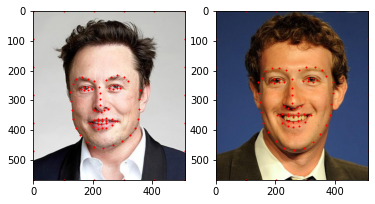

In [24]:
plt.subplot(1, 2, 1)
plt.scatter(landmark1[:, 0], landmark1[:,1], s=1, color='red')
plt.imshow(image1)
plt.subplot(1, 2, 2)
plt.scatter(landmark2[:, 0], landmark2[:,1], s=1, color='red')
plt.imshow(image2)

## Constructing triangles

Functions for determining points in triangle

In [25]:
def barycentric(p, p1, p2):
    '''
    Support an array of points 2D
    '''
    return np.sign((p[:,0] - p2[0]) * (p1[1] - p2[1]) - (p1[0] - p2[0]) * (p[:,1] - p2[1]))

def in_triangle(points, tri_coord):
    '''
    Support an array of points
    '''
    # d1, d2, d3 = all the points' area sign with edge 1, 2, 3 
    d1 = barycentric(points, tri_coord[0], tri_coord[1])
    d2 = barycentric(points, tri_coord[1], tri_coord[2])
    d3 = barycentric(points, tri_coord[2], tri_coord[0])

    return np.where((d1==d2)&(d2==d3))

def segmented_image_cv(img_dim, tri_coords):
    import cv2
    H, W = img_dim
    output = np.zeros((H, W))
    n_tri = tri_coords.shape[0]
    for k in range(n_tri):
        cv2.fillConvexPoly(output, tri_coords[k], k)
    return output

def segmented_image(img_dim, tri_coords):
    H, W = img_dim
    output = np.zeros((H, W))
    output = output.flatten()
    y, x = np.mgrid[0:H, 0:W]
    all_positions = np.append(x.reshape(-1,1),y.reshape(-1,1),axis=1)
    n_tri = tri_coords.shape[0]
    for k in range(n_tri):
        points_in_k = in_triangle(all_positions, tri_coords[k])
        output[points_in_k] = k
    output = output.reshape((H, W))
    return output

Only need the triangulation of one set of landmarks and take the indices. This is because the landmarks have an order corresponding to each other.

In [26]:
tri1 = Delaunay(landmark1)

simplices1 = tri1.simplices
points1_tri = landmark1[simplices1]
simplices2 = tri1.simplices
points2_tri = landmark2[simplices1]

Showing the triangles

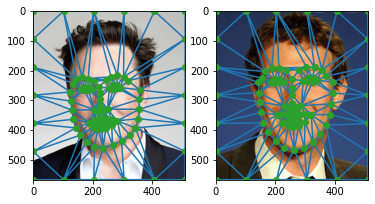

In [27]:
plt.subplot(1, 2, 1)
plt.triplot(landmark1[:,0], landmark1[:,1], simplices1)
plt.imshow(image1)
plt.plot(landmark1[:,0], landmark1[:,1], 'o')
plt.subplot(1, 2, 2)
plt.triplot(landmark2[:,0], landmark2[:,1], simplices2)
plt.imshow(image2)
plt.plot(landmark2[:,0], landmark2[:,1], 'o')
plt.show()

Determining which point is in which triangle, visualizing it to make sure the order are the same. Also useful for later.

In [28]:
seg1 = segmented_image_cv(image1.shape[:-1], points1_tri)
seg2 = segmented_image_cv(image2.shape[:-1], points2_tri)

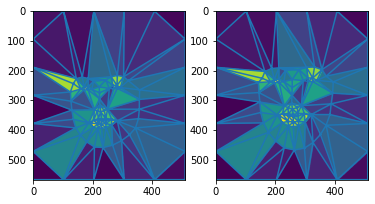

In [29]:
plt.subplot(1, 2, 1)
plt.imshow(seg1)
plt.triplot(landmark1[:,0], landmark1[:,1], simplices1)

plt.subplot(1, 2, 2)
plt.imshow(seg2)
plt.triplot(landmark2[:,0], landmark2[:,1], simplices2)
plt.show()

## Create the intermediate image triangles

In [30]:
n_frames = 50
ratio = np.linspace(0, 1, n_frames)
triangles = [] # [I1, I2, I3, ... I10] of triangles
for i in range(n_frames):
    new_coords = (1-ratio[i])*points1_tri + ratio[i]*points2_tri
    triangles.append(new_coords.astype(np.int32))

## Estimating affine warp

In [31]:
def getAffineWarp(prev, next):
    """
    Should be shape: [[x1, y1], [x2, y2], [x3, y3]] (3x2)
    """
    length = prev.shape[0]
    prev = np.hstack((prev, np.ones((length, 1))))
    next = np.hstack((next, np.ones((length, 1))))
    W = np.linalg.pinv(prev) @ next
    return W

In [32]:
tri_in_frame = triangles[0].shape[0]
warps = np.zeros((n_frames-1, tri_in_frame, 3, 3))
Inv_warps = np.zeros((n_frames-1, tri_in_frame, 3, 3))

for frame in range(n_frames-1):
    this_tris = triangles[frame] 
    next_tris = triangles[frame+1]
    for i in range(tri_in_frame):
        warp = getAffineWarp(this_tris[i], next_tris[i])
        warps[frame, i] = warp
        Inv_warps[frame, i] = np.linalg.pinv(warp)

## Mapping all the points in triangles

[[     0      1      2 ...    509    510    511]
 [   512    513    514 ...   1021   1022   1023]
 [  1024   1025   1026 ...   1533   1534   1535]
 ...
 [289280 289281 289282 ... 289789 289790 289791]
 [289792 289793 289794 ... 290301 290302 290303]
 [290304 290305 290306 ... 290813 290814 290815]] [[     0      1      2 ...    509    510    511]
 [     0      1      2 ...    509    510    511]
 [     0      1      2 ...    509    510    511]
 ...
 [241152 241153 241154 ... 241661 241662 241663]
 [241664 241665 241666 ... 242173 242174 242175]
 [242176 242177 242178 ... 242685 242686 242687]]


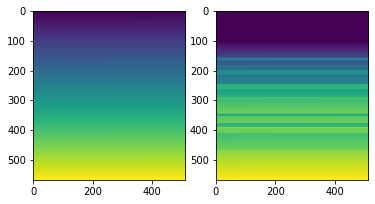

In [42]:
# get the color blend
import cv2
H, W, C = image1.shape

# start_frame = np.arange(0, H*W)
# start_frame = start_frame.reshape((H, W))
# end_frame = np.copy(start_frame)
# for k in range(tri_in_frame):
#     warp = getAffineWarp(triangles[0][k], triangles[-1][k])
#     this_warp = np.linalg.pinv(warp)
#     empty = np.zeros((H, W))
#     cv2.fillConvexPoly(empty, triangles[frame][k], 1)
#     coords_in_tri = np.column_stack(np.nonzero(empty))
#     coords_with_bias= np.hstack((coords_in_tri, np.ones((coords_in_tri.shape[0], 1)))).astype(int) # bias terms
#     prev_pos = coords_with_bias @ this_warp
#     prev_pos = prev_pos[:, :-1].T / prev_pos[:,-1]
#     lower_bounds = np.array([0, 0])
#     upper_bounds = np.array([H-1, W-1])
#     prev_pos = np.clip(prev_pos.T, lower_bounds, upper_bounds)
#     prev_pos = prev_pos.astype(int)
#     end_frame[coords_in_tri] = start_frame[prev_pos]

# plt.subplot(1, 2, 1)
# plt.imshow(start_frame)
# plt.subplot(1, 2, 2)
# plt.imshow(end_frame)

In [46]:

pixel_maps = []
starting = np.arange(0, H*W)
starting = starting.reshape((H, W))
pixel_maps.append(starting)
for frame in range(1, n_frames):
    print("mapping frame ", frame+1)
    H, W, _ = image1.shape
    last_frame = pixel_maps[frame-1]
    new_frame = np.zeros((H, W), dtype=int)
    # segments = segs[frame] # the affliation of each point with triangles for this frame
    inv_warp = Inv_warps[frame-1, :, :, :] # get how the last frame is transformed to this frame
    for k in range(tri_in_frame):
        # print(k)
        this_warp = inv_warp[k,:,:]
        empty = np.zeros((H, W))
        cv2.fillConvexPoly(empty, triangles[frame][k], 1)
        coords_in_tri = np.column_stack(np.nonzero(empty))
        coords_with_bias= np.hstack((coords_in_tri, np.ones((coords_in_tri.shape[0], 1)))).astype(int) # bias terms
        prev_pos = coords_with_bias @ this_warp
        prev_pos = prev_pos[:, :-1].T / prev_pos[:,-1]
        lower_bounds = np.array([0, 0])
        upper_bounds = np.array([H-1, W-1])
        prev_pos = np.clip(prev_pos.T, lower_bounds, upper_bounds)
        prev_pos = prev_pos.astype(int)
        new_frame[coords_in_tri] = last_frame[prev_pos]
    pixel_maps.append(new_frame)

mapping frame  2
mapping frame  3
mapping frame  4
mapping frame  5
mapping frame  6
mapping frame  7
mapping frame  8
mapping frame  9
mapping frame  10
mapping frame  11
mapping frame  12
mapping frame  13
mapping frame  14
mapping frame  15
mapping frame  16
mapping frame  17
mapping frame  18
mapping frame  19
mapping frame  20
mapping frame  21
mapping frame  22
mapping frame  23
mapping frame  24
mapping frame  25
mapping frame  26
mapping frame  27
mapping frame  28
mapping frame  29
mapping frame  30
mapping frame  31
mapping frame  32
mapping frame  33
mapping frame  34
mapping frame  35
mapping frame  36
mapping frame  37
mapping frame  38
mapping frame  39
mapping frame  40
mapping frame  41
mapping frame  42
mapping frame  43
mapping frame  44
mapping frame  45
mapping frame  46
mapping frame  47
mapping frame  48
mapping frame  49
mapping frame  50


In [49]:
def get_color(position_array, start_img):
    shape = start_img.shape
    new_img = start_img.reshape((-1,3))
    new_img = new_img[position_array]
    return new_img.reshape(shape)

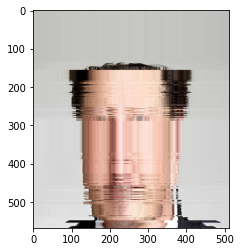

In [55]:
xx = get_color(pixel_maps[49], image1)
plt.imshow(xx)